# Capstone 3: Image Classification<a id='IC'></a>

## Contents<a id='Contents'></a>
* [Image Classification](#IC)
  * [Contents](#Contents)
  * [Introduction](#Introduction)
  * [Imports](#Imports)
  * [Data Wrangling and Exploratory Data Analysis](#DWEDA)  
      * [Load the Data](#Load_the_Data)
      * [Data Wrangling](#Data_Wrangling)
      * [Exploratory Data Analysis](#EDA)
      * [Image Analysis](#Image_Analysis)
  * [Pre-processing and Models](#PPM)
      * [Pre-processing](#PP)
      * [Models](#Models)
          * [Image Classification](#IC)
          * [Classification with Metadata](#CM)
  * [Conclusions](#Conclusions)

## Introduction<a id='Introduction'></a>

It can often be beneficial to use machine learning to supplement the work done by doctors in diagnosing cases where the problem can be visually seen either externally with images or internally using different X-ray and CT imaging techniques. Machine learning applications by no means replace the diagnosis of a trained medical professional, but can be useful in preliminary screening as well as differentiating conditions, especially those which are often close in appearance, as is the case with this dataset. This can also help to reduce medical staff workload, especially in areas where medical personnel are stretched thin. As part of this analysis, I will be looking at machine learning models geared towrards both the image data as well as the image metadata, in order to accurately diagnose certain skin lesions.

## Imports<a id='Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import datetime
import time
import PIL.Image as Image
import skimage as sk
from skimage import color, filters, exposure, data, transform, morphology, restoration, util, segmentation, measure, feature
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.naive_bayes import GaussianNB
%load_ext tensorboard

C:\Users\jmhat\AppData\Roaming\Python\Python38\site-packages\dask\config.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## Data Wrangling and Exploratory Data Analysis<a id='DWEDA'></a>

### Load the Data<a id='Load_the_Data'></a>

In [2]:
#At this stage, I'll only import the metadata file
image_metadata = pd.read_csv('C:/Users/jmhat/Desktop/Coding/Capstone3/Data/HAM10000_metadata.csv')

The metadata dataframe contains information on the lesion id, image id, diagnosis (dx), diagnosis method (dx_type), age, sex, and location of the lesion (localization). <br>

There are 7 different types of lesions in the dataset including: <br>
> akiec - Actinic keratoses and intraepithelial carcinoma/Bowen's disease <br>
bcc - Basal cell carcinoma <br>
bkl - Benign keratosis-like lesions (solar lentigines/seborrheic keratoses and lichen-planus-like keratoses <br>
df - Dermatofibroma <br>
mel - Melanoma <br>
nv - Melanocytic nevi <br>
vasc - Vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage)

There are 4 different types of diagnosis methods in the dataset including: <br>
> histo - Histopathology <br>
follow_up - Follow-up examination <br>
consensus - Expert consensus <br>
confocal - In-vivo confocal microscopy <br>

In [3]:
image_metadata.shape

(10015, 7)

In [4]:
image_metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### Data Wrangling<a id='Data_Wrangling'></a>

In [5]:
#Rename the dx, dx_type, and localization columns to make them clearer
image_metadata.rename(columns={'dx': 'diagnosis', 'dx_type':'diagnosis_method', 'localization':'location'}, inplace=True)

In [6]:
image_metadata.head()

,lesion_id,image_id,diagnosis,diagnosis_method,age,sex,location
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
image_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lesion_id         10015 non-null  object 
 1   image_id          10015 non-null  object 
 2   diagnosis         10015 non-null  object 
 3   diagnosis_method  10015 non-null  object 
 4   age               9958 non-null   float64
 5   sex               10015 non-null  object 
 6   location          10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


A preliminary look at the data shows there are at least 57 ages missing and possibly other values mislabeled in the other columns. I'll use the value counts function to inspect the columns of interest. I'll make one long string for these values, meaning I need to convert age to a string as well and then add them all together. I will use a copy of the original dataset for this work so as to not disturb the original data.

In [8]:
image_metadata_copy = image_metadata.copy()

In [9]:
image_metadata_copy = image_metadata_copy.astype({'age': 'str'})

In [10]:
image_metadata_copy['diag_method_age_sex_location'] = image_metadata_copy['diagnosis'] + ' ' + image_metadata_copy['diagnosis_method'] + ' ' + image_metadata_copy['age'] + ' ' + image_metadata_copy['sex'] + ' ' + image_metadata_copy['location']

In [11]:
pd.options.display.max_rows = 1450

In [12]:
image_metadata_copy['diag_method_age_sex_location'].value_counts()

nv follow_up 45.0 female trunk                130
nv follow_up 45.0 female lower extremity      122
nv follow_up 50.0 male trunk                  112
nv follow_up 50.0 female trunk                107
nv follow_up 45.0 male lower extremity         93
nv follow_up 50.0 female lower extremity       88
nv follow_up 45.0 male trunk                   85
nv follow_up 55.0 female lower extremity       85
nv follow_up 40.0 female trunk                 74
nv follow_up 40.0 male trunk                   71
nv follow_up 50.0 male lower extremity         67
nv follow_up 40.0 female lower extremity       65
nv follow_up 45.0 male back                    65
nv follow_up 55.0 male trunk                   65
nv follow_up 55.0 male lower extremity         62
nv follow_up 35.0 male lower extremity         60
nv follow_up 50.0 male abdomen                 59
nv follow_up 55.0 female trunk                 58
nv follow_up 45.0 male abdomen                 57
nv follow_up 45.0 female abdomen               56


After inspecting the above value counts, along with the missing ages, there are also many 'unknown' entries. I will replace the 'unknown' entries and missing ages with the most common for each category below

In [13]:
#Replace missing values with most common entry for the remaining columns
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 40.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 55.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'upper extremity'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 25.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'lower extremity'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 60.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 35.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'abdomen'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 35.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'follow_up') & (image_metadata['age'] == 55.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'lower extremity'
image_metadata.loc[(image_metadata['diagnosis'] == 'bkl') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 40.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'abdomen'
image_metadata.loc[(image_metadata['diagnosis'] == 'mel') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 75.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 70.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'trunk'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 10.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'upper extremity'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 30.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 30.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 55.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'lower extremity'
image_metadata.loc[(image_metadata['diagnosis'] == 'bkl') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 75.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'bkl') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 80.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'lower extremity'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 35.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 85.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 85.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'bcc') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 70.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'mel') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 80.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'upper extremity'
image_metadata.loc[(image_metadata['diagnosis'] == 'mel') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 45.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'bkl') & (image_metadata['diagnosis_method'] == 'confocal') & (image_metadata['age'] == 40.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'face'
image_metadata.loc[(image_metadata['diagnosis'] == 'bcc') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 45.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'follow_up') & (image_metadata['age'] == 60.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'lower extremity'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'follow_up') & (image_metadata['age'] == 50.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'trunk'
image_metadata.loc[(image_metadata['diagnosis'] == 'mel') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 70.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'mel') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 75.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'bkl') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 50.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'upper extremity'
image_metadata.loc[(image_metadata['diagnosis'] == 'bkl') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 65.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'upper extremity'
image_metadata.loc[(image_metadata['diagnosis'] == 'bkl') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 60.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'follow_up') & (image_metadata['age'] == 70.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'trunk'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'follow_up') & (image_metadata['age'] == 50.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'trunk'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'follow_up') & (image_metadata['age'] == 45.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'trunk'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 50.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'bkl') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 60.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'face'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 75.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 80.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 55.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 40.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 45.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'lower extremity'
image_metadata.loc[(image_metadata['diagnosis'] == 'bcc') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 60.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 40.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'lower extremity'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 45.0) & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'unknown'), 'location'] = 'foot'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'] == 25.0) & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'unknown'), 'location'] = 'back'

image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 60.0) & (image_metadata['location'] == 'foot') & (image_metadata['sex'] == 'unknown'), 'sex'] = 'female'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 35.0) & (image_metadata['location'] == 'trunk') & (image_metadata['sex'] == 'unknown'), 'sex'] = 'female'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 45.0) & (image_metadata['location'] == 'abdomen') & (image_metadata['sex'] == 'unknown'), 'sex'] = 'male'
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['age'] == 0.0) & (image_metadata['location'] == 'back') & (image_metadata['sex'] == 'unknown'), 'sex'] = 'male'


In [14]:
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'trunk') & (image_metadata['age'].isnull() == True), 'age'] = 35.0
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'abdomen') & (image_metadata['age'].isnull() == True), 'age'] = 35.0
image_metadata.loc[(image_metadata['diagnosis'] == 'mel') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'face') & (image_metadata['age'].isnull() == True), 'age'] = 65.0
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'foot') & (image_metadata['age'].isnull() == True), 'age'] = 0.0
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['sex'] == 'female') & (image_metadata['location'] == 'chest') & (image_metadata['age'].isnull() == True), 'age'] = 25.0
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'histo') & (image_metadata['sex'] == 'male') & (image_metadata['location'] == 'upper extremity') & (image_metadata['age'].isnull() == True), 'age'] = 45.0

In [15]:
image_metadata.loc[(image_metadata['diagnosis'] == 'bkl') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'].isnull() == True) & (image_metadata['sex'] == 'unknown') & (image_metadata['location'] == 'unknown'), ['age', 'sex', 'location']] = [70.0, 'female', 'trunk']
image_metadata.loc[(image_metadata['diagnosis'] == 'nv') & (image_metadata['diagnosis_method'] == 'consensus') & (image_metadata['age'].isnull() == True) & (image_metadata['sex'] == 'unknown') & (image_metadata['location'] == 'unknown'), ['age', 'sex', 'location']] = [40.0, 'female', 'lower extremity']

Now that these have been replaced, I'll double check the values to ensure I am not missing any ages or unknown entries.

In [16]:
#Check values again
image_metadata_updated_copy = image_metadata.copy()
image_metadata_updated_copy = image_metadata_updated_copy.astype({'age': 'str'})
image_metadata_updated_copy['diag_method_age_sex_location'] = image_metadata_updated_copy['diagnosis'] + ' ' + image_metadata_updated_copy['diagnosis_method'] + ' ' + image_metadata_updated_copy['age'] + ' ' + image_metadata_updated_copy['sex'] + ' ' + image_metadata_updated_copy['location']
pd.options.display.max_rows = 1450
image_metadata_updated_copy['diag_method_age_sex_location'].value_counts()

nv follow_up 45.0 female trunk                131
nv follow_up 45.0 female lower extremity      122
nv follow_up 50.0 male trunk                  113
nv follow_up 50.0 female trunk                109
nv follow_up 45.0 male lower extremity         93
nv consensus 40.0 female lower extremity       89
nv follow_up 55.0 female lower extremity       88
nv follow_up 50.0 female lower extremity       88
nv follow_up 45.0 male trunk                   85
nv follow_up 40.0 female trunk                 74
nv follow_up 40.0 male trunk                   71
nv follow_up 50.0 male lower extremity         67
nv follow_up 55.0 male trunk                   65
nv follow_up 45.0 male back                    65
nv follow_up 40.0 female lower extremity       65
nv follow_up 55.0 male lower extremity         62
nv follow_up 35.0 male lower extremity         60
nv follow_up 50.0 male abdomen                 59
nv follow_up 55.0 female trunk                 58
nv follow_up 45.0 male abdomen                 57


In [17]:
image_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lesion_id         10015 non-null  object 
 1   image_id          10015 non-null  object 
 2   diagnosis         10015 non-null  object 
 3   diagnosis_method  10015 non-null  object 
 4   age               10015 non-null  float64
 5   sex               10015 non-null  object 
 6   location          10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [18]:
image_metadata.head()

,lesion_id,image_id,diagnosis,diagnosis_method,age,sex,location
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [19]:
image_metadata['diagnosis'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: diagnosis, dtype: int64

In [20]:
image_metadata['diagnosis_method'].value_counts()

histo        5340
follow_up    3704
consensus     902
confocal       69
Name: diagnosis_method, dtype: int64

In [21]:
image_metadata['sex'].value_counts()

male      5410
female    4605
Name: sex, dtype: int64

In [22]:
image_metadata['location'].value_counts()

back               2263
lower extremity    2178
trunk              1421
upper extremity    1136
abdomen            1031
face                748
chest               407
foot                334
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: location, dtype: int64

In [23]:
image_metadata.duplicated().value_counts()

False    10015
dtype: int64

The metadata is now complete with no missing values. However, the lesion_id column doesn't add much benefit to our classification model, so I will remove it to simplify the process moving forward.

In [24]:
#Drop the lesion_id column since this doesn't add any extra data to our model
image_metadata.drop('lesion_id', axis=1, inplace=True)

In [25]:
image_metadata.head()

,image_id,diagnosis,diagnosis_method,age,sex,location
0,ISIC_0027419,bkl,histo,80.0,male,scalp
1,ISIC_0025030,bkl,histo,80.0,male,scalp
2,ISIC_0026769,bkl,histo,80.0,male,scalp
3,ISIC_0025661,bkl,histo,80.0,male,scalp
4,ISIC_0031633,bkl,histo,75.0,male,ear


### Exploratory Data Analysis<a id='EDA'></a>

Let's take a quick look at some of these features to see what their relationships are to each other and if there are any preliminary trends we can deduce.

In [29]:
metadata_numeric = image_metadata.copy()

In [30]:
#Replace diagnosis categorical variables with get_dummies method
metadata_numeric = pd.get_dummies(metadata_numeric, columns=['diagnosis'], drop_first=False)

In [31]:
#Replace diagnosis method with dummy variables
metadata_numeric = pd.get_dummies(metadata_numeric, columns=['diagnosis_method'], drop_first=False)

In [32]:
#Replace gender with dummy variables
metadata_numeric = pd.get_dummies(metadata_numeric, columns=['sex'], drop_first=False)

In [33]:
#Replace location with dummy variables
metadata_numeric = pd.get_dummies(metadata_numeric, columns=['location'], drop_first=False)

In [34]:
#We don't need the image id numbers, so I will drop those columns
metadata_cont = metadata_numeric.drop(columns=['image_id'])

Using the metadata as numerical values, we can plot a correlation matrix to determine any preliminary correlations between the features.

Correlation between continuous features


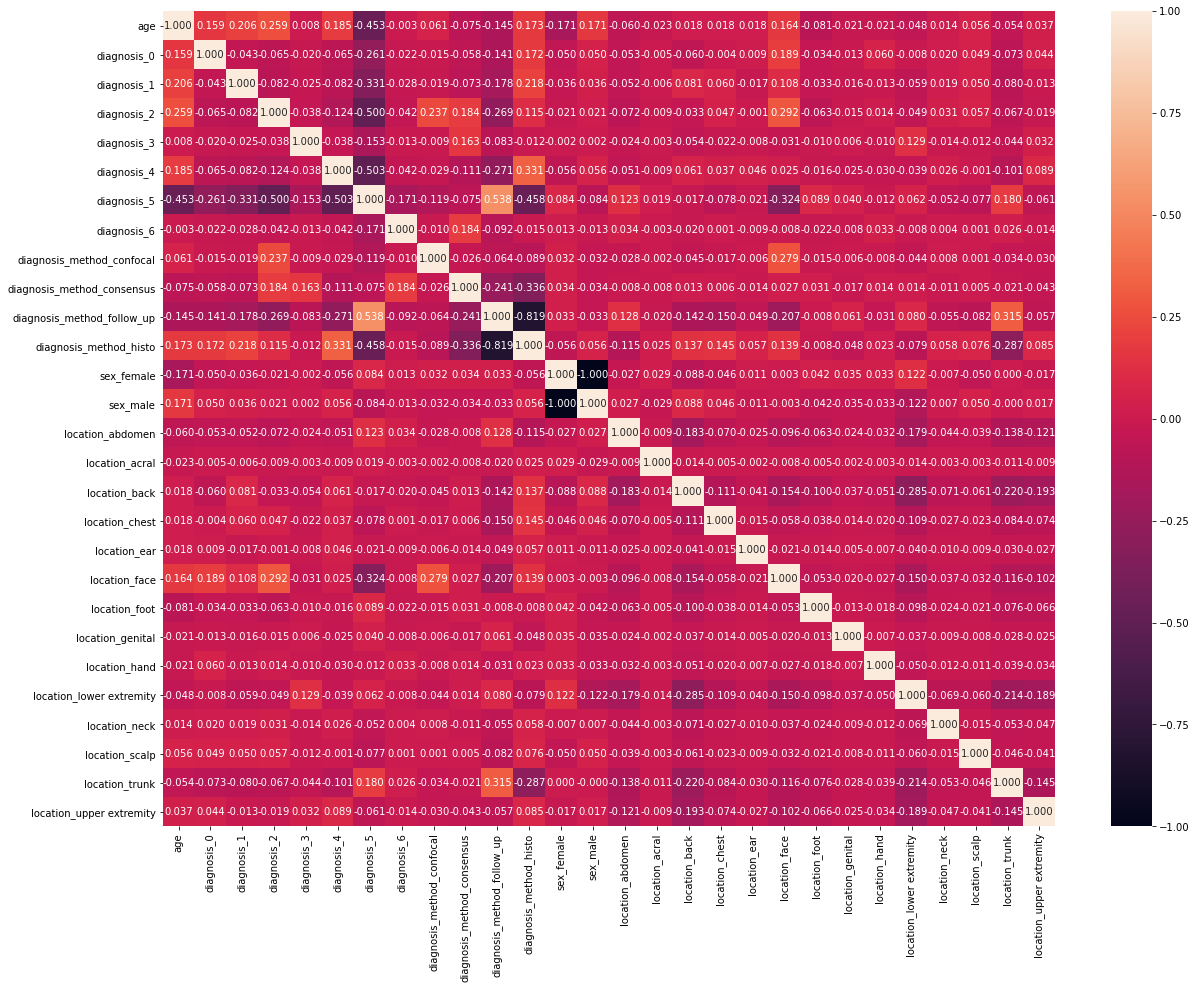

In [35]:
plt.figure(figsize=(20,15))
print('Correlation between continuous features')
p=sns.heatmap(metadata_cont.corr(), annot=True, fmt='.3f')

As can be seen from the correlation matrix, there are some positive and negative correlations between the features and the diagnoses. Already, these can give a hint as to what type of lesion a patient has based off of its features, such as location, age, and diagnosis method. There are definitely both positive and negative correlations between locations, diagnosis methods and diagnoses. This seems to show some interesting correlations between how diagnoses are made and their location on the body. The highest correlations seem to be between the diagnoses and their diagnosis methods. Moving forward, I will first run a simple classification model using just the images and the diagnoses. Then I will create a classification model using just the image metadata to see if that information is more important than the images in determining the type of lesion.

Text(0.5, 1.0, 'Distribution of Diagnoses')

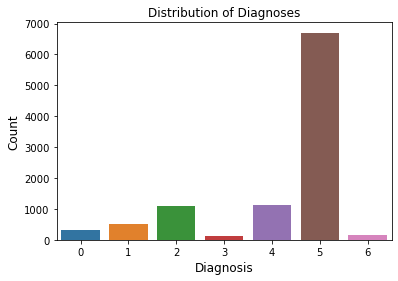

In [36]:
#Display the distribution of diagnosis from the metadata
sns.countplot(x = 'diagnosis', data=image_metadata)
plt.xlabel('Diagnosis', size=12)
plt.ylabel('Count', size=12)
plt.title('Distribution of Diagnoses', size=12)

From this bar graph of metadata, we can see that most lesions in this dataset are classified as Melanocytic nevi.

Text(0.5, 1.0, 'Distribution of Diagnosis Methods')

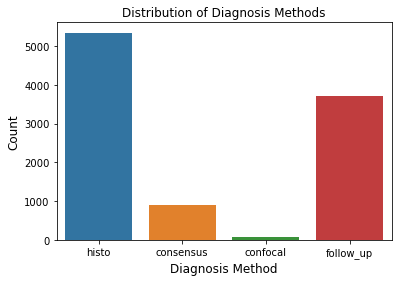

In [37]:
#Display the distribution of diagnosis methods from the metadata
sns.countplot(x = 'diagnosis_method', data=image_metadata)
plt.xlabel('Diagnosis Method', size=12)
plt.ylabel('Count', size=12)
plt.title('Distribution of Diagnosis Methods', size=12)

There also appears to be two dominent methods for determining the type of lesion for each patient. The most popular method was histopathology followed by follow-up examination.

Text(0.5, 1.0, 'Distribution of Lesion Locations')

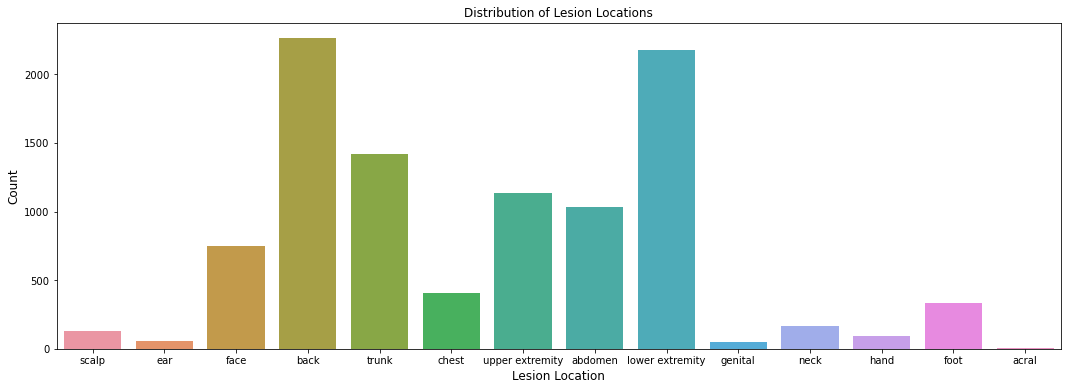

In [38]:
#Display the ditribution of lesion locations from the metadata
bar, ax = plt.subplots(figsize = (18,6))
sns.countplot(x = 'location', data=image_metadata)
plt.xlabel('Lesion Location', size=12)
plt.ylabel('Count', size=12)
plt.title('Distribution of Lesion Locations', size=12)

The majority of lesion locations were divided amongst 6 different anatomical locations, with the most being found on the back and lower extremities.

Text(0.5, 1.0, 'Distribution of Patient Gender')

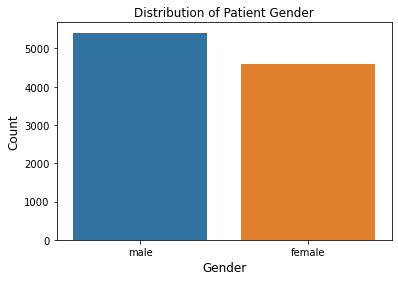

In [39]:
sns.countplot(x = 'sex', data=image_metadata)
plt.xlabel('Gender', size=12)
plt.ylabel('Count', size=12)
plt.title('Distribution of Patient Gender', size=12)

Slightly more males were included in this dataset. This could indicate that males tend to have more skin lesions, but that could just be because this dataset was imbalanced as collected. Further sampling would be needed to verify this information.

Text(0.5, 1.0, 'Histogram of Patient Ages')

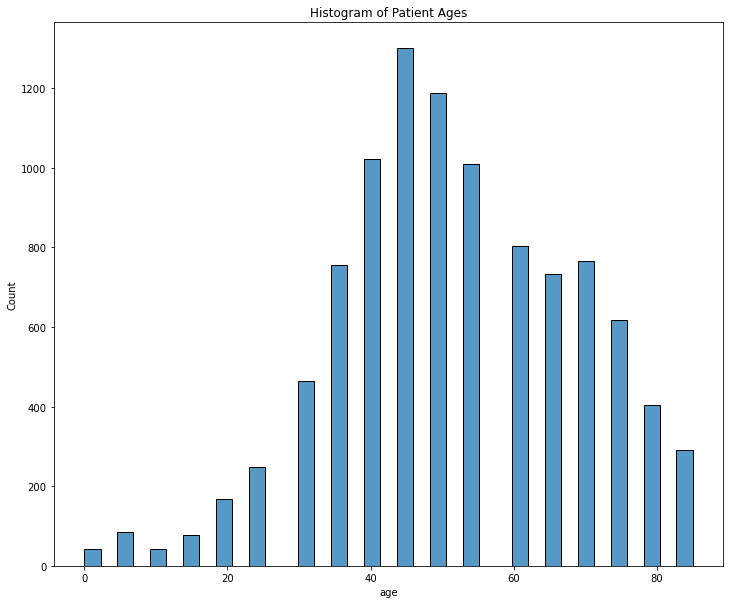

In [40]:
bar, ax = plt.subplots(figsize=(12,10))
sns.histplot(image_metadata['age'])
plt.title('Histogram of Patient Ages')

The majority of patients who were diagnosed with skin lesions in this dataset tend to be in their early to mid-forties and early fifties. This distribution seems to be slightly left-skewed but fairly close to a normal distribution.

In [41]:
metadata_cont.describe()

,age,diagnosis_0,diagnosis_1,diagnosis_2,diagnosis_3,diagnosis_4,diagnosis_5,diagnosis_6,diagnosis_method_confocal,diagnosis_method_consensus,...,location_ear,location_face,location_foot,location_genital,location_hand,location_lower extremity,location_neck,location_scalp,location_trunk,location_upper extremity
count,10015.00000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,...,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000
mean,51.82027,0.032651,0.051323,0.109735,0.011483,0.111133,0.669496,0.014179,0.006890,0.090065,...,0.005592,0.074688,0.033350,0.004793,0.008987,0.217474,0.016775,0.012781,0.141887,0.113430
std,16.96831,0.177730,0.220667,0.312575,0.106546,0.314313,0.470418,0.118233,0.082722,0.286289,...,0.074571,0.262900,0.179558,0.069067,0.094375,0.412548,0.128433,0.112333,0.348952,0.317133
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,65.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,85.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The summary statistics support the previous histogram. The average age is about 52 years old.

### Image Analysis<a id='Image_Analysis'></a>

Now that the metadata is cleaned up, I also want to run some exploratory data analysis with the raw images. There are 10,015 images which correspond to the entries in the metadata file. I first want to take a look at the images to determine the best path forward with incorporating the images in my analysis. I'll look at some of the different color channels as well as the size of the images, and some helpful functions that may be of further use in the analysis.

In [22]:
#Create a function to display an image
def display_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [23]:
image1 = plt.imread('C:/Users/jmhat/Desktop/Coding/Capstone3/Data/Images/nv/ISIC_0024306.jpg')

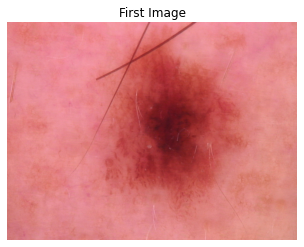

In [24]:
display_image(image1, 'First Image')

In [39]:
#Image size in pixels
image1.shape

(450, 600, 3)

In [40]:
#Total number of pixels
image1.size

810000

In [41]:
#Slice image into red, green, and blue channels
red = image1[:, :, 0]
green = image1[:, :, 1]
blue = image1[:, :, 2]

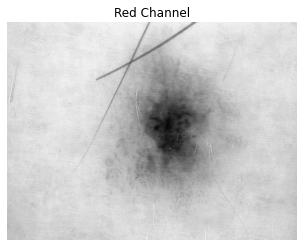

In [42]:
#Display image using red, green, and blue channels as grayscale images
plt.imshow(red, cmap='gray')
plt.title('Red Channel')
plt.axis('off')
plt.show()

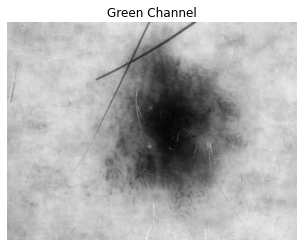

In [43]:
plt.imshow(green, cmap='gray')
plt.title('Green Channel')
plt.axis('off')
plt.show()

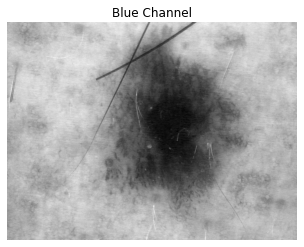

In [44]:
plt.imshow(blue, cmap='gray')
plt.title('Blue Channel')
plt.axis('off')
plt.show()

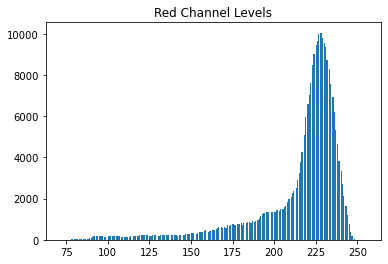

In [45]:
#Histograms of RGB channel levels
plt.hist(red.ravel(), bins=256)
plt.title('Red Channel Levels')
plt.show()

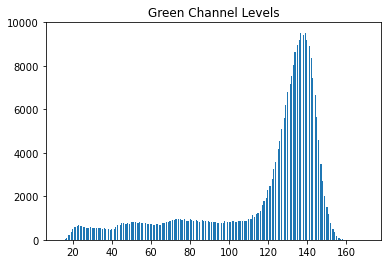

In [46]:
plt.hist(green.ravel(), bins=256)
plt.title('Green Channel Levels')
plt.show()

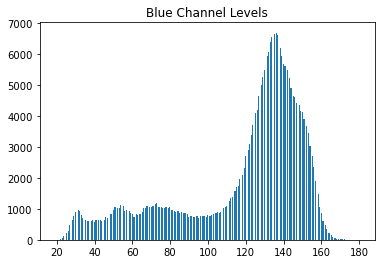

In [47]:
plt.hist(blue.ravel(), bins=256)
plt.title('Blue Channel Levels')
plt.show()

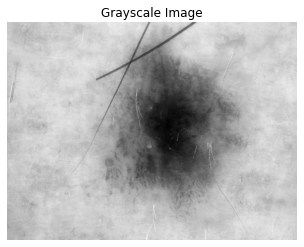

In [48]:
#Turn image to grayscale
grayscale_image1 = sk.color.rgb2gray(image1)
display_image(grayscale_image1, 'Grayscale Image')

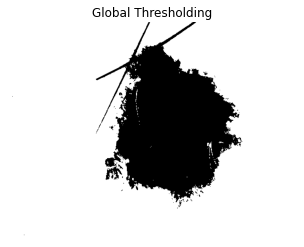

In [49]:
#Apply thresholds
thresh = sk.filters.threshold_otsu(grayscale_image1)
binary_global = grayscale_image1 > thresh
display_image(binary_global, 'Global Thresholding')

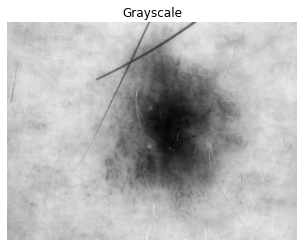

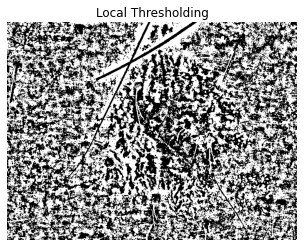

In [50]:
#Apply local threshold
block_size = 35
local_thresh = sk.filters.threshold_local(grayscale_image1, block_size)
binary_local = grayscale_image1 > local_thresh
display_image(grayscale_image1, 'Grayscale')
display_image(binary_local, 'Local Thresholding')

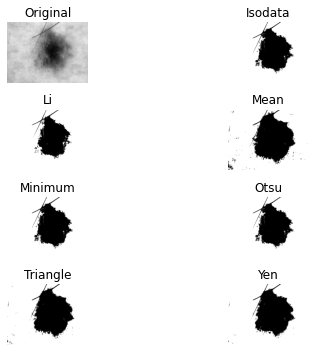

In [51]:
#Apply more thresholdings
fig, ax = sk.filters.try_all_threshold(grayscale_image1, verbose=False)
plt.show()

Some thresholding types worked better than others in isolated the affected skin area, but with each, other features, such as hair, is also picked up and may adversely affect the model. There could be potential for using thresholded images as they do take out some of the nuances from the color images, however, I believe that the color may also provide a level of differentiation that could help the model. Next, I'll take a look at some edge detection methods to see how they work with these images.

In [52]:
#Apply edge detection
def plot_comparison(original, filtered, title_filtered):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,6), sharex=True, sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(title_filtered)
    ax2.axis('off')

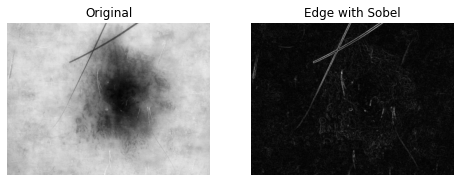

In [53]:
#Sobel edge detection
edge_sobel = filters.sobel(grayscale_image1)
plot_comparison(grayscale_image1, edge_sobel, 'Edge with Sobel')

Edges using Sobel didn't quite show any useful data, so I will process the image further to see if other edge representations work more effectively.

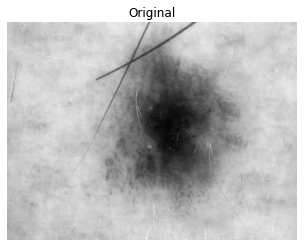

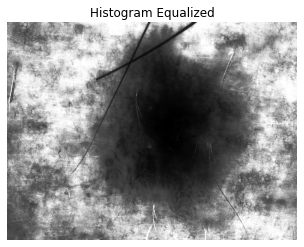

In [54]:
#Apply equalization to the exposure
image_eq = exposure.equalize_hist(grayscale_image1)
display_image(grayscale_image1, 'Original')
display_image(image_eq, 'Histogram Equalized')

This seemed to wash out the original size of the lesion, but could be more indicitive of the extensive damage caused by these type of lesions.

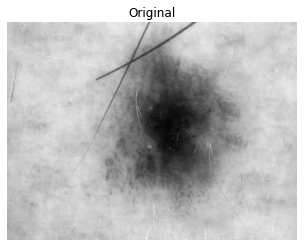

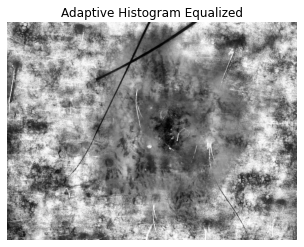

In [55]:
#Apply adaptive equalization to the exposure
image_adeq = exposure.equalize_adapthist(grayscale_image1, clip_limit=0.03)
display_image(grayscale_image1, 'Original')
display_image(image_adeq, 'Adaptive Histogram Equalized')

Again, not very useful for the model, but I suspect this could be very useful for medical professionals to get a different view of the skin conditions and any other damage not immediately visible to the naked eye.

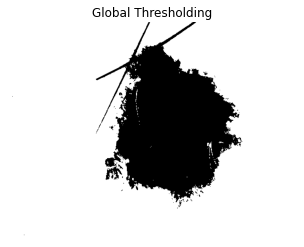

In [56]:
#Apply Isodata thresholds
thresh_iso = filters.threshold_isodata(grayscale_image1)
binary_global_iso = grayscale_image1 > thresh_iso
display_image(binary_global_iso, 'Global Thresholding')

Similar to the initial thersholding, this probably won't be very useful beyond this point.

In [57]:
#Create a function to show the image contours
def show_image_contour(image, contours):
    plt.figure()
    for n, contour in enumerate(contours):
        plt.plot(contour[:,1], contour[:,0], linewidth=3)
    plt.imshow(image, interpolation='nearest', cmap='gray_r')
    plt.title('Contours')
    plt.axis('off')
    plt.show()

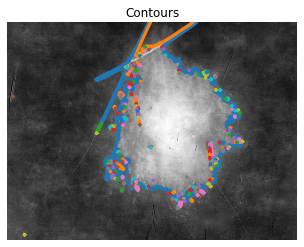

In [58]:
#Display lesion contours
contours = measure.find_contours(binary_global_iso, 0.8)
show_image_contour(grayscale_image1, contours)

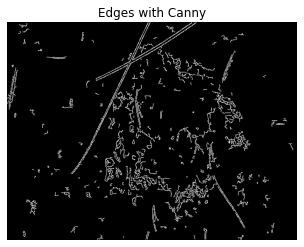

In [59]:
#Edges with Canny
canny_edges = feature.canny(grayscale_image1, sigma=0.0)
display_image(canny_edges, 'Edges with Canny')

After reviewing the different image processing options available, we can see that each option provides different kinds of information about the lesion. Some of this data may be especially helpful in visual classification and spread of the lesion on the patient's skin. However, since skin lesions often have different colors as well as shapes, it may still be more beneficial to feed the color images to our model for analysis. Since this is solely a high level analysis, I will use the raw images for my machine learning models.

## Pre-processing and Models<a id='PPM'></a>

Create the required datasets for the keras model.

In [52]:
#Create datasets for tensorflow keras
batch_size = 128
img_height = 450
img_width = 600
data_dir = 'C:/Users/jmhat/Desktop/Coding/Capstone3/Data/Images'

In [53]:
train_images = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset='training', seed=47, image_size=(img_height, img_width), batch_size=batch_size)

Found 10015 files belonging to 7 classes.
Using 8012 files for training.


In [54]:
val_images = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset='validation', seed=47, image_size=(img_height, img_width), batch_size=batch_size)

Found 10015 files belonging to 7 classes.
Using 2003 files for validation.


In [55]:
class_names = train_images.class_names
print(class_names)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


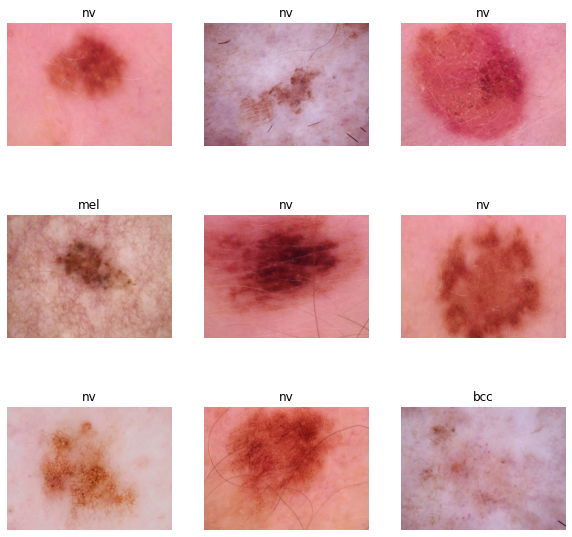

In [48]:
#Show the first nine images from the training dataset with their labels
plt.figure(figsize=(10, 10))
for images, labels in train_images.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

At this point, I am ready to move forward with configuring the dataset for the keras model through standardization. I will then implement the model. After that, I will then move towards creating a wide and deep model using all the features from the image metadata.

### Pre-processing<a id='PP'></a>

For the metadata classification model, I need to use diagnosis as my target variable, and the image, diagnosis_method, age, sex, and location as features. I will first modify my features to work with a classification problem using just the images. I'm now going to replace the string values for diagnosis with numerical values.

In [42]:
image_metadata['diagnosis'] = image_metadata['diagnosis'].replace(['akiec','bcc','bkl','df','mel','nv','vasc'],[0, 1, 2, 3, 4, 5, 6])

In [43]:
image_metadata.head()

,image_id,diagnosis,diagnosis_method,age,sex,location
0,ISIC_0027419,2,histo,80.0,male,scalp
1,ISIC_0025030,2,histo,80.0,male,scalp
2,ISIC_0026769,2,histo,80.0,male,scalp
3,ISIC_0025661,2,histo,80.0,male,scalp
4,ISIC_0031633,2,histo,75.0,male,ear


In order to run a basic keras model with the images alone, I need to sort the images into subfolders by diagnosis.

In [ ]:
#In order to sort the data into different folders, we need lists of image_id for each diagnosis
diag_akiec = image_metadata.query('diagnosis == 0')['image_id']
diag_akiec = list(diag_akiec + '.jpg')

In [ ]:
diag_bcc = image_metadata.query('diagnosis == 1')['image_id']
diag_bcc = list(diag_bcc + '.jpg')

In [ ]:
diag_bkl = image_metadata.query('diagnosis == 2')['image_id']
diag_bkl = list(diag_bkl + '.jpg')

In [ ]:
diag_df = image_metadata.query('diagnosis == 3')['image_id']
diag_df = list(diag_df + '.jpg')

In [ ]:
diag_mel = image_metadata.query('diagnosis == 4')['image_id']
diag_mel = list(diag_mel + '.jpg')

In [ ]:
diag_nv = image_metadata.query('diagnosis == 5')['image_id']
diag_nv = list(diag_nv + '.jpg')

In [ ]:
diag_vasc = image_metadata.query('diagnosis == 6')['image_id']
diag_vasc = list(diag_vasc + '.jpg')

In [ ]:
source_1 = 'C:/Users/jmhat/Desktop/Coding/Capstone3/Data/HAM10000_images_part_1'
source_2 = 'C:/Users/jmhat/Desktop/Coding/Capstone3/Data/HAM10000_images_part_2'
dest_akiec = 'C:/Users/jmhat/Desktop/Coding/Capstone3/Data/Images/akiec'
dest_bcc = 'C:/Users/jmhat/Desktop/Coding/Capstone3/Data/Images/bcc'
dest_bkl = 'C:/Users/jmhat/Desktop/Coding/Capstone3/Data/Images/bkl'
dest_df = 'C:/Users/jmhat/Desktop/Coding/Capstone3/Data/Images/df'
dest_mel = 'C:/Users/jmhat/Desktop/Coding/Capstone3/Data/Images/mel'
dest_nv = 'C:/Users/jmhat/Desktop/Coding/Capstone3/Data/Images/nv'
dest_vasc = 'C:/Users/jmhat/Desktop/Coding/Capstone3/Data/Images/vasc'

files_1 = os.listdir(source_1)
files_2 = os.listdir(source_2)


for a in files_1:
    if a in diag_akiec:
        shutil.move(source_1 + '\\' + a, dest_akiec)
        
for b in files_2:
    if b in diag_akiec:
        shutil.move(source_2 + '\\' + b, dest_akiec)
        
for c in files_1:
    if c in diag_bcc:
        shutil.move(source_1 + '\\' + c, dest_bcc)
        
for d in files_2:
    if d in diag_bcc:
        shutil.move(source_2 + '\\' + d, dest_bcc)
        
for e in files_1:
    if e in diag_bkl:
        shutil.move(source_1 + '\\' + e, dest_bkl)
        
for f in files_2:
    if f in diag_bkl:
        shutil.move(source_2 + '\\' + f, dest_bkl)
        
for g in files_1:
    if g in diag_df:
        shutil.move(source_1 + '\\' + g, dest_df)
        
for h in files_2:
    if h in diag_df:
        shutil.move(source_2 + '\\' + h, dest_df)
        
for i in files_1:
    if i in diag_mel:
        shutil.move(source_1 + '\\' + i, dest_mel)
        
for j in files_2:
    if j in diag_mel:
        shutil.move(source_2 + '\\' + j, dest_mel)
        
for k in files_1:
    if k in diag_nv:
        shutil.move(source_1 + '\\' + k, dest_nv)
        
for l in files_2:
    if l in diag_nv:
        shutil.move(source_2 + '\\' + l, dest_nv)

for m in files_1:
    if m in diag_vasc:
        shutil.move(source_1 + '\\' + m, dest_vasc)
        
for n in files_2:
    if n in diag_vasc:
        shutil.move(source_2 + '\\' + n, dest_vasc)

Configure dataset performance using cache and prefetch

In [56]:
AUTOTUNE = tf.data.AUTOTUNE

train_images = train_images.cache().prefetch(buffer_size=AUTOTUNE)
val_images = val_images.cache().prefetch(buffer_size=AUTOTUNE)

### Models<a id='Models'></a>

#### Image Classification<a id='IC'></a>

This initial model consists of 3 convolution blocks and a max pooling layer in each of them. There's also a fully connected layer with 128 units on top of it that is activated by a ReLU function.

In [58]:
num_classes = len(class_names)

In [70]:
model = keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [55]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 450, 600, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 450, 600, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 225, 300, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 225, 300, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 150, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 150, 64)      1

Train this model

In [91]:
epochs=10
history = model.fit(train_images, validation_data=val_images, epochs=epochs)

Epoch 1/10
251/251 [==============================] - 1259s 5s/step - loss: 1.0746 - accuracy: 0.6669 - val_loss: 0.9201 - val_accuracy: 0.6860
Epoch 2/10
251/251 [==============================] - 1252s 5s/step - loss: 0.8500 - accuracy: 0.6933 - val_loss: 0.9870 - val_accuracy: 0.6890
Epoch 3/10
251/251 [==============================] - 1267s 5s/step - loss: 0.7639 - accuracy: 0.7230 - val_loss: 0.8753 - val_accuracy: 0.7069
Epoch 4/10
251/251 [==============================] - 1237s 5s/step - loss: 0.6717 - accuracy: 0.7535 - val_loss: 0.7843 - val_accuracy: 0.7104
Epoch 5/10
251/251 [==============================] - 1252s 5s/step - loss: 0.5742 - accuracy: 0.7907 - val_loss: 0.9539 - val_accuracy: 0.7014
Epoch 6/10
251/251 [==============================] - 1233s 5s/step - loss: 0.5185 - accuracy: 0.8118 - val_loss: 1.0157 - val_accuracy: 0.7054
Epoch 7/10
251/251 [==============================] - 1224s 5s/step - loss: 0.4586 - accuracy: 0.8303 - val_loss: 1.1235 - val_accuracy:

Visualize the training results

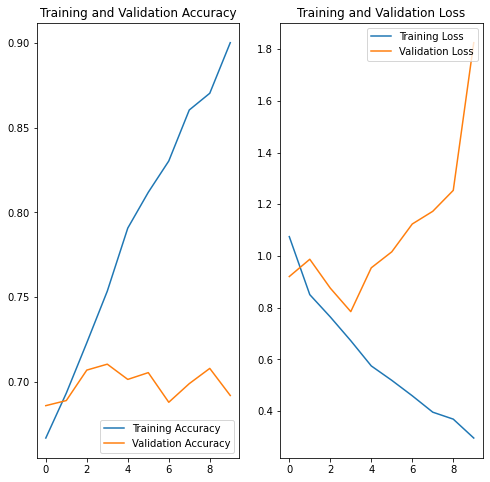

In [92]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The training and validation accuracy are drastically different. The model only achieved around 70% accuracy on the validation set. The loss shows that this model is drastically overfitting the data. Using data augmentation, I will try to adjust the model to prevent overfitting. I will also apply a dropout layer to the model.

In [93]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [94]:
model = keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [95]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [96]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 450, 600, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 450, 600, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 450, 600, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 225, 300, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 225, 300, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 150, 32)     0         
 2D)                                                  

In [97]:
epochs = 15
history = model.fit(
  train_images,
  validation_data=val_images,
  epochs=epochs
)

Epoch 1/15
251/251 [==============================] - 1494s 6s/step - loss: 1.1038 - accuracy: 0.6653 - val_loss: 0.9229 - val_accuracy: 0.6890
Epoch 2/15
251/251 [==============================] - 1472s 6s/step - loss: 0.8561 - accuracy: 0.6830 - val_loss: 0.8434 - val_accuracy: 0.6950
Epoch 3/15
251/251 [==============================] - 1463s 6s/step - loss: 0.8289 - accuracy: 0.6945 - val_loss: 0.7671 - val_accuracy: 0.7199
Epoch 4/15
251/251 [==============================] - 1454s 6s/step - loss: 0.7815 - accuracy: 0.7114 - val_loss: 0.8075 - val_accuracy: 0.7114
Epoch 5/15
251/251 [==============================] - 1462s 6s/step - loss: 0.7511 - accuracy: 0.7162 - val_loss: 0.7541 - val_accuracy: 0.7264
Epoch 6/15
251/251 [==============================] - 1464s 6s/step - loss: 0.7334 - accuracy: 0.7254 - val_loss: 0.7229 - val_accuracy: 0.7304
Epoch 7/15
251/251 [==============================] - 1451s 6s/step - loss: 0.7227 - accuracy: 0.7270 - val_loss: 0.7299 - val_accuracy:

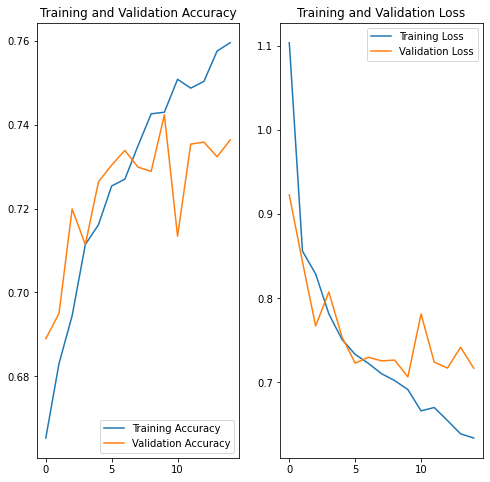

In [98]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After applying the data augmentation and dropout, there is less overfitting and the accuracy is much closer between the training and validation images. We are still only achieving about 76% accuracy with the training data and 73% accuracy with the validation data. This isn't as high as we would like, but further optimization may lead to overfitting.

In [101]:
img = tf.keras.utils.load_img(
    'C:/Users/jmhat/Desktop/Coding/Capstone3/Data/df/ISIC_0032410.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 102ms/step
This image most likely belongs to bcc with a 58.74 percent confidence.


This model does a much better job at predicting classes, although still struggles. I want to experiment with the arguements of the convolutional layers and possibly increase the dropout to avoid overfitting. 15 epoches also seemed to work well with this analysis.

In [63]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [64]:
model = keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [65]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [66]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 450, 600, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 450, 600, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 450, 600, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 225, 300, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 225, 300, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 112, 150, 32)     0         
 2D)                                                  

In [67]:
epochs = 15
history = model.fit(
  train_images,
  validation_data=val_images,
  epochs=epochs
)

Epoch 1/15
63/63 [==============================] - 1721s 27s/step - loss: 1.6854 - accuracy: 0.6464 - val_loss: 0.9755 - val_accuracy: 0.6715
Epoch 2/15
63/63 [==============================] - 1504s 24s/step - loss: 0.9395 - accuracy: 0.6692 - val_loss: 0.9241 - val_accuracy: 0.6855
Epoch 3/15
63/63 [==============================] - 1538s 24s/step - loss: 0.8671 - accuracy: 0.6787 - val_loss: 0.8497 - val_accuracy: 0.6885
Epoch 4/15
63/63 [==============================] - 1526s 24s/step - loss: 0.8233 - accuracy: 0.6923 - val_loss: 0.8179 - val_accuracy: 0.6970
Epoch 5/15
63/63 [==============================] - 1524s 24s/step - loss: 0.8070 - accuracy: 0.6998 - val_loss: 0.7989 - val_accuracy: 0.6930
Epoch 6/15
63/63 [==============================] - 1504s 24s/step - loss: 0.7756 - accuracy: 0.7137 - val_loss: 0.8056 - val_accuracy: 0.6975
Epoch 7/15
63/63 [==============================] - 1481s 23s/step - loss: 0.7554 - accuracy: 0.7227 - val_loss: 0.8081 - val_accuracy: 0.6980

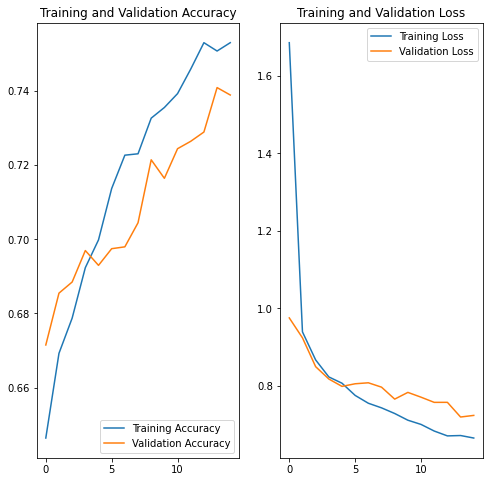

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Classification with Metadata<a id='CM'></a>

In [70]:
image_metadata

,image_id,diagnosis,diagnosis_method,age,sex,location
0,ISIC_0027419,2,histo,80.0,male,scalp
1,ISIC_0025030,2,histo,80.0,male,scalp
2,ISIC_0026769,2,histo,80.0,male,scalp
3,ISIC_0025661,2,histo,80.0,male,scalp
4,ISIC_0031633,2,histo,75.0,male,ear
...,...,...,...,...,...,...
10010,ISIC_0033084,0,histo,40.0,male,abdomen
10011,ISIC_0033550,0,histo,40.0,male,abdomen
10012,ISIC_0033536,0,histo,40.0,male,abdomen
10013,ISIC_0032854,0,histo,80.0,male,face


In [72]:
#Replace diagnosis method with dummy variables
image_metadata = pd.get_dummies(image_metadata, columns=['diagnosis_method'], drop_first=False)

In [73]:
#Replace gender with dummy variables
image_metadata = pd.get_dummies(image_metadata, columns=['sex'], drop_first=False)

In [74]:
#Replace location with dummy variables
image_metadata = pd.get_dummies(image_metadata, columns=['location'], drop_first=False)

In [75]:
#We don't need the image id numbers, so I will drop those columns
image_metadata = image_metadata.drop(columns=['image_id'])

In [76]:
image_metadata

,diagnosis,age,diagnosis_method_confocal,diagnosis_method_consensus,diagnosis_method_follow_up,diagnosis_method_histo,sex_female,sex_male,location_abdomen,location_acral,...,location_ear,location_face,location_foot,location_genital,location_hand,location_lower extremity,location_neck,location_scalp,location_trunk,location_upper extremity
0,2,80.0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2,80.0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2,80.0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2,80.0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2,75.0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,0,40.0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
10011,0,40.0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
10012,0,40.0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
10013,0,80.0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [78]:
#Split the data into training and testing sections
X = image_metadata.drop(columns=['diagnosis'])
y = image_metadata['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
#Random Forest Model
clf = RandomForestClassifier(n_estimators=200)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7299051422865701


In [105]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.21      0.12      0.15        69
           1       0.29      0.24      0.26        93
           2       0.48      0.43      0.45       228
           3       0.73      0.29      0.41        28
           4       0.36      0.24      0.29       226
           5       0.84      0.95      0.89      1338
           6       0.46      0.29      0.35        21

    accuracy                           0.73      2003
   macro avg       0.48      0.36      0.40      2003
weighted avg       0.69      0.73      0.71      2003



In [103]:
#Updated Random Forest Model
clf1 = RandomForestClassifier(n_estimators=200, min_samples_split=2, class_weight='balanced')
clf1.fit(X_train, y_train)
y_pred = clf1.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.21      0.57      0.30        69
           1       0.16      0.40      0.23        93
           2       0.46      0.30      0.37       228
           3       0.14      0.54      0.22        28
           4       0.28      0.34      0.30       226
           5       0.98      0.71      0.82      1338
           6       0.17      0.62      0.27        21

    accuracy                           0.60      2003
   macro avg       0.34      0.50      0.36      2003
weighted avg       0.75      0.60      0.65      2003



In [83]:
eec = EasyEnsembleClassifier(random_state=42)
eec_model = eec.fit(X_train, y_train)
y_pred = eec_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.15      0.62      0.24        69
           1       0.18      0.32      0.23        93
           2       0.56      0.13      0.21       228
           3       0.08      0.71      0.14        28
           4       0.24      0.22      0.23       226
           5       0.96      0.68      0.80      1338
           6       0.07      0.29      0.11        21

    accuracy                           0.54      2003
   macro avg       0.32      0.43      0.28      2003
weighted avg       0.75      0.54      0.61      2003



In [95]:
# training a KNN classifier
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train)
  
# accuracy on X_test
accuracy = knn.score(X_test, y_test)
print(accuracy)
  
# creating a confusion matrix
knn_predictions = knn.predict(X_test) 
cm = confusion_matrix(y_test, knn_predictions)

0.6944583125312032


In [96]:
print(classification_report(y_test, knn_predictions))

              precision    recall  f1-score   support

           0       0.19      0.26      0.22        69
           1       0.18      0.23      0.20        93
           2       0.41      0.42      0.41       228
           3       0.50      0.14      0.22        28
           4       0.32      0.27      0.29       226
           5       0.88      0.89      0.88      1338
           6       0.00      0.00      0.00        21

    accuracy                           0.69      2003
   macro avg       0.35      0.32      0.32      2003
weighted avg       0.69      0.69      0.69      2003



In [97]:
# training a Naive Bayes classifier
gnb = GaussianNB().fit(X_train, y_train)
gnb_predictions = gnb.predict(X_test)
print(classification_report(y_test, gnb_predictions))

              precision    recall  f1-score   support

           0       0.15      0.38      0.22        69
           1       0.12      0.51      0.19        93
           2       1.00      0.04      0.07       228
           3       0.05      0.96      0.09        28
           4       0.25      0.04      0.06       226
           5       1.00      0.55      0.71      1338
           6       0.05      0.24      0.09        21

    accuracy                           0.43      2003
   macro avg       0.37      0.39      0.20      2003
weighted avg       0.82      0.43      0.51      2003



After running a few different classification models with the image metadata, it appears that the best overall model was the basic random forest classifier with 200 estimators. Interestingly, the overall accuracy of this model appears to be almost identical to the accuracy achieved by the best image classification model of around 73%. I want to see what features are the most important in predicting the type of lesion the patient will be diagnosed with.

In [106]:
importances = clf.feature_importances_

# Sort the feature importance in descending order
sorted_indices = np.argsort(importances)[::-1]
 
feat_labels = image_metadata.columns[1:]
 
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importances[sorted_indices[f]]))

 1) age                            0.427587
 2) diagnosis_method_follow_up     0.165373
 3) diagnosis_method_histo         0.129168
 4) location_face                  0.073817
 5) diagnosis_method_consensus     0.033783
 6) diagnosis_method_confocal      0.019101
 7) location_trunk                 0.017453
 8) location_abdomen               0.015076
 9) location_lower extremity       0.014709
10) sex_female                     0.014360
11) sex_male                       0.013888
12) location_back                  0.013663
13) location_upper extremity       0.012668
14) location_foot                  0.012094
15) location_chest                 0.009936
16) location_neck                  0.007215
17) location_scalp                 0.007185
18) location_hand                  0.006941
19) location_ear                   0.004187
20) location_genital               0.001508
21) location_acral                 0.000288


The most important feature for predicting the type of lesion appears to be age, by a large margin. The next highest is the follow up diagnosis method.

## Conclusions<a id='Conclusions'></a>

The question that began this process was whether we could predict the type of skin lesion a patient had based on an image of the lesion and metadata information, such as diagnosis, diagnosis method, age, gender, and other features. In order to answer this question, I broke this problem up into two parts, focusing on the images and metadata separately. First, there was a large amount of data cleaning that needed to be done so that the dataset would be ready for machine learning. Since there were many unique combinations of features, I found the most common ones and used those to fill in any missing values or "unknown" values. 

During exploratory data analysis there were definitely both positive and negative correlations between locations, diagnosis methods and diagnoses. There were also some interesting correlations between how diagnoses are made and their location on the body. The highest correlations seem to be between the diagnoses and their diagnosis methods. I then decided to plot some histograms of the data to visualize any important trends in the dataset. I first looked at the diagnosis types and found that the majority of lesions were classified as Melanocytic nevi. After researching this, it is actually quite common to find these on patients and are actually rarely cancerous. As far as diagnosis methods, histopathology and follow up are the most common. Histopathology involves the microscopic examination of a biopsy that is processed by applying one or more dyes to stain the specimen with different colors. Lesion locations varied greatly, with the majority of locations spread among six different locations. Lesions were most often seen on patient's backs and lower extremity. Patient gender was almost equally spread with slightly more patients identifying as male. Ages varied between newborn and 85 years old, with the majority of patients being in their late fourties and early fifties.

After exploring the metadata, I also wanted to take a look at the images and see if further image processing could help with the modeling. I broke down one of the images into its red, green, and blue channels, as well as applied different edge detection and thresholding methods. These methods actually showed some interesting information, although I felt that this information would not be as benefial for machine learning. The different thresholding methods were especially intersting to show the extent of lesion growth on the skin and also other damaged areas on the skin. I wanted to use the original images for the classification process since it would include the color information, which can often distinctly classify a lesion as one type or another. However, I belive that the thresholding and edge detection methods would be especially import for doctors to have access to in order to better determine the type of lesions and other features not immediately noticable to the naked eye.

The last part of this process was to run machine learning models for both the images and metadata and compare the results. Starting with the images, I decided to use tensorflow keras to create a sequential classification model with multiple layers. This model uses rescaling, convolutional layers, max pooling, flatten, dropout, and dense layers. In order to optimize the model, I rescaled the pixel greyscale values to be between 0 and 1. The convolutional layer is a linear operation that multiplies a set of weights with the input values. Max pooling layers are used to help prevent overfitting by providing an abstracted form of the representation. It also saves on computational costs by reducing the number of parameters to learn. Flattening converts the data from a multi-dimensional array into a 1D array for passing into the next layer. Dropout layers also help to prevent overfitting of data. Finally, the dense layer is the final step to classify the images based off of the previous layers. For the first model, I did not use a dropout layer, and the accuracy on the test data was constant while the loss split very quickly, indicating a high level of overfitting. For the second run, along with a dropout layer for the overfitting issues, I also applied random flips, rotations, and zooms on the images to help with classification. After these changes, the testing accuracy and testing loss greatly improved. The only change was that the training accuracy decreased from the first model. I then wanted to experiment with the dropout value and increased it from 0.2 to 0.5. This created a model very similar to the previous results, with possibly a little less overfitting as shown on the loss curves. This model produced an accuracy of around 74%.

Finally, I also wanted to run a classification model based on just the image metadata. I first started with a basic random forest model which produced an accuracy of about 73%, very close to the image classification accuracy. I then tried a more balanced random forest model, since there are different amounts of each type of lesion. This model produced an accuracy less than the original basic random forest model. I also tried an easy ensemble classifier, K-nearest neighbors model, and a Naive Bayes model. The best of these was the easy ensemble model, but the accuracy was less than the normal random forest model. The K-nearest neighbors model also had a difficult time predicting the last class, giving every metric 0.0. I then took the basic random forest model and looked at which features were most important in classifying lesions. It turns out the best feature was patient age, followed by diagnosis methods of follow up and histopathology. This makes sense as both male and female patients have all types of lesions and the real only method to diagnose lesions is through doctor intervention either by visual inspection or further testing through biopsy.

As part of this process, I also wanted to highlight the potential for moving forward with the analysis. If I were to continue this analysis, I would look into using a wide and deep learning model to potentially combine the metadata and image classification. This may help increase the overall accuracy. It may also be useful to use cloud computing to increase the power of the models and use higher level convolutional layers.